# SVM - Jack Le - Polygence


### Data Use Agreements
The data used for this project were provided in part by OASIS and ADNI.

OASIS-3: Principal Investigators: T. Benzinger, D. Marcus, J. Morris; NIH P50 AG00561, P30 NS09857781, P01 AG026276, P01 AG003991, R01 AG043434, UL1 TR000448, R01 EB009352. AV-45 doses were provided by Avid Radiopharmaceuticals, a wholly owned subsidiary of Eli Lilly.

Data collection for this project was done through the Alzheimer's Disease Neuroimaging Initiative (ADNI) (National Institutes of Health Grant U01 AG024904) and DOD ADNI (Department of Defense award number W81XWH-12-2-0012). ADNI is funded by the National Institute on Aging, the National Institute of Biomedical Imaging and Bioengineering, and through generous contributions from the following: AbbVie, Alzheimer’s Association; Alzheimer’s Drug Discovery Foundation; Araclon Biotech; BioClinica, Inc.; Biogen; Bristol-Myers Squibb Company; CereSpir, Inc.; Cogstate; Eisai Inc.; Elan Pharmaceuticals, Inc.; Eli Lilly and Company; EuroImmun; F. Hoffmann-La Roche Ltd and its affiliated company Genentech, Inc.; Fujirebio; GE Healthcare; IXICO Ltd.; Janssen Alzheimer Immunotherapy Research & Development, LLC.; Johnson & Johnson Pharmaceutical Research & Development LLC.; Lumosity; Lundbeck; Merck & Co., Inc.; Meso Scale Diagnostics, LLC.; NeuroRx Research; Neurotrack Technologies; Novartis Pharmaceuticals Corporation; Pfizer Inc.; Piramal Imaging; Servier; Takeda Pharmaceutical Company; and Transition Therapeutics. The Canadian Institutes of Health Research is providing funds to support ADNI clinical sites in Canada. Private sector contributions are facilitated by the Foundation for the National Institutes of Health (www.fnih.org). The grantee organization is the Northern California Institute for Research and Education, and the study is coordinated by the Alzheimer’s Therapeutic Research Institute at the University of Southern California. ADNI data are disseminated by the Laboratory for Neuro Imaging at the University of Southern California.

## Working with Image Data using IncrementalPCA and SGDClassifer
Steps
1. load the data and read the paths to each image file and save it to an img_paths array
2. split the img_paths array into a training and testing set
3. loop through the training set of img_paths list in batches of __ (choose size of batch)
4. loop through the batch, using nibabel to load the image data of each scan, then flatten it using numpy
5. append this flattened array to a list
6. pass the list into IncrementalPCA partial_fit
7. once all batches are looped through and IncrementalPCA is fully fit, loop through each batch again and apply the transformation
8. pass this transformed batch into the partial_fit method of SGDCLassifer
9. once SGD is fully fit, loop through the testing set in batches and apply pca to each batch, then use that batch to predict results
10. compare results to find accuracy

### Imports

In [1]:
import os
import pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nibabel.freesurfer.mghformat as mgh

from tqdm.notebook import tqdm

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

### Read in csv data for organization

In [2]:
rootdir = '/home/jack/Code/GitHub/Polygence/'
df = pd.read_csv(rootdir + 'Data/OASIS/oasis_3.csv')
df.head()

,Subject,MR ID,id,Age,M/F,dx1,mmse,cdr,apoe,TOTAL_HIPPOCAMPUS_VOLUME,...,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
0,OAS30001,OAS30001_MR_d3132,OAS30001_Freesurfer53_d3132,73.0,F,Cognitively normal,30.0,0.0,23.0,6861.9,...,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
1,OAS30001,OAS30001_MR_d0129,OAS30001_Freesurfer53_d0129,65.0,F,Cognitively normal,30.0,0.0,23.0,7678.9,...,187528.786036,379446.180091,50687.0,517683.180091,8.105851e+05,184600.488060,182662.445419,367262.933479,70168.1,69483.8
2,OAS30001,OAS30001_MR_d2430,OAS30001_Freesurfer53_d2430,71.0,F,Cognitively normal,30.0,0.0,23.0,7105.9,...,178872.680224,357784.489639,49058.0,487405.489639,7.779313e+05,175955.968883,178172.812666,354128.781549,67905.7,68000.2
3,OAS30001,OAS30001_MR_d0757,OAS30001_Freesurfer53_d0757,67.0,F,Cognitively normal,29.0,0.0,23.0,7648.2,...,177566.874682,362040.150904,50071.0,500699.150904,7.993419e+05,185224.779932,188151.990316,373376.770247,69142.3,68558.8
4,OAS30002,OAS30002_MR_d2345,OAS30002_Freesurfer53_d2345,73.0,M,Cognitively normal,29.0,0.0,34.0,7833.2,...,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3


In [3]:
df = df.dropna(axis=1, how='all') # Drop any empty columns
df = df.dropna(axis=0, how='any') # Drop any rows with empty values 
df = df.rename(columns={'id':'FS ID', 'dx1':'Diagnosis'}) # Rename columns
df = df.drop_duplicates(subset='Subject', keep='first') # Keep only the first visit
df = df.reset_index(drop=True) # Reset the index
df.loc[df['cdr'] < 0.5, 'Diagnosis'] = 'control'
df.loc[~(df['cdr'] < 0.5), 'Diagnosis'] = 'dementia'
df['Diagnosis'].replace(['control','dementia'], [-1,1], inplace=True)
df = df.drop(df.columns.difference(['Subject', 'MR ID', 'FS ID', 'Diagnosis']), 1) # Drop all columns unless needed
print(df.shape)

(1022, 4)


In [4]:
df.head()

,Subject,MR ID,FS ID,Diagnosis
0,OAS30001,OAS30001_MR_d3132,OAS30001_Freesurfer53_d3132,-1
1,OAS30002,OAS30002_MR_d2345,OAS30002_Freesurfer53_d2345,-1
2,OAS30003,OAS30003_MR_d2682,OAS30003_Freesurfer53_d2682,-1
3,OAS30004,OAS30004_MR_d2232,OAS30004_Freesurfer53_d2232,-1
4,OAS30005,OAS30005_MR_d2377,OAS30005_Freesurfer53_d2377,-1


Text(0.5, 1.0, '-1 is control, 1 is dementia')

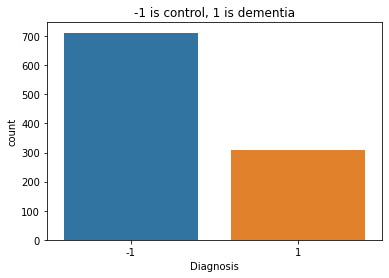

In [5]:
sns.countplot(x='Diagnosis', data=df)
plt.title('-1 is control, 1 is dementia')

### Step 1 - Load the data and add paths onto the df

In [6]:
data_dir = rootdir + 'Data/OASIS/data/'
ids = os.listdir(data_dir)
for id in ids:
    mr_dir = os.path.join(data_dir, id)
    img_file = [file for file in os.listdir(mr_dir) if "transformed" in file]
    img_path = os.path.join(mr_dir, img_file[0])
    
    mr_id = mr_dir[mr_dir.rfind('/')+1:]
    df.loc[df['MR ID'] == mr_id, 'Path'] = img_path

print(df.shape)

(1022, 5)


In [7]:
df.head(5)

,Subject,MR ID,FS ID,Diagnosis,Path
0,OAS30001,OAS30001_MR_d3132,OAS30001_Freesurfer53_d3132,-1,/home/jack/Code/GitHub/Polygence/Data/OASIS/data/OAS30001_MR_d3132/OAS30001_Freesurfer53_d3132_brain_transformed.mgz
1,OAS30002,OAS30002_MR_d2345,OAS30002_Freesurfer53_d2345,-1,/home/jack/Code/GitHub/Polygence/Data/OASIS/data/OAS30002_MR_d2345/OAS30002_Freesurfer53_d2345_brain_transformed.mgz
2,OAS30003,OAS30003_MR_d2682,OAS30003_Freesurfer53_d2682,-1,/home/jack/Code/GitHub/Polygence/Data/OASIS/data/OAS30003_MR_d2682/OAS30003_Freesurfer53_d2682_brain_transformed.mgz
3,OAS30004,OAS30004_MR_d2232,OAS30004_Freesurfer53_d2232,-1,/home/jack/Code/GitHub/Polygence/Data/OASIS/data/OAS30004_MR_d2232/OAS30004_Freesurfer53_d2232_brain_transformed.mgz
4,OAS30005,OAS30005_MR_d2377,OAS30005_Freesurfer53_d2377,-1,/home/jack/Code/GitHub/Polygence/Data/OASIS/data/OAS30005_MR_d2377/OAS30005_Freesurfer53_d2377_brain_transformed.mgz


### Step 2 - split the img_paths into a training and testing set

In [8]:
X = df['Path']
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(817,) (817,) (205,) (205,)


### Main loop

In [9]:
# icpa = IncrementalPCA()
# batch_size = 50
# for batch_idx, X_df in tqdm(X_train.groupby(np.arange(len(X_train)) // batch_size), desc='Batch id'):
#     X_data = []
#     for idx, path in tqdm(X_df.iteritems(), desc='Image'):
#         image_obj = mgh.load(path)
#         image_data = image_obj.get_fdata()
#         flat = image_data.flatten()
#         X_data.append(flat)
#     X_data = np.array(X_data)
#     icpa.partial_fit(X_data)
#     print(icpa.n_samples_seen_)

In [18]:
samp_df = df.groupby(['Diagnosis']).apply(lambda x: x.sample(n=25, random_state=0)).reset_index(drop = True)
X_data = []
for idx, row in tqdm(samp_df.iterrows(), desc='Image', total=samp_df.shape[0]):
    path = row['Path']
    image_obj = mgh.load(path)
    image_data = image_obj.get_fdata()
    flat = image_data.flatten()
    X_data.append(flat)

Image:   0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
ipca = IncrementalPCA(n_components=50)

In [20]:
ipca.partial_fit(X_data)

/home/jack/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_incremental_pca.py:316: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/home/jack/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IncrementalPCA(n_components=50)

In [21]:
print(ipca.n_samples_seen_)
print(ipca.explained_variance_ratio_.cumsum())

50
[0.1101766  0.14962012 0.18624374 0.21741254 0.24750689 0.27730677
 0.30477262 0.33005956 0.35421709 0.37754948 0.40036158 0.42156025
 0.44247179 0.46304432 0.48292204 0.50254033 0.52172139 0.54024394
 0.55843217 0.57621908 0.59387866 0.61152234 0.62853229 0.64520673
 0.6615367  0.67775323 0.69373074 0.70958436 0.72537378 0.74077704
 0.7560394  0.77126206 0.78626232 0.8011535  0.81573102 0.83008291
 0.84436403 0.85853718 0.87263183 0.88665222 0.90023829 0.91333879
 0.92623598 0.93905003 0.95165447 0.96410137 0.97631003 0.98842671
 1.         1.        ]


In [24]:
X_ipca = ipca.transform(X_data)

In [25]:
print(X_ipca.shape)

(50, 50)
